## Import Dependencies & Azure Keys

In [1]:
import pandas as pd
import pyodbc
import os
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore") # Get rid of warnings        
from sklearn.decomposition import PCA
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from faker import Faker # Make Synthetic Data
from sdv.tabular import GaussianCopula
from sklearn.svm import SVR

##* Azure Keys (Don't Share) *##
server = 'sustprediction.database.windows.net'
database = 'sustainability'
username = 'capstone'
password = '{ds440@grp6}'   
driver= '{ODBC Driver 17 for SQL Server}'

## Fetch Data NYC Version 2

Retrieve NYC data from Azure SQL Database

🔑 Stores Data On RAM


In [2]:
def nyc_v2():
    """
    1. Get the dataset as dataframe.
    2. Get the column names for the dataset separately from Azure.
    """

    conn = pyodbc.connect('DRIVER='+driver+';SERVER=tcp:'+server+';PORT=1433;DATABASE='+database+';UID='+username+';PWD='+ password)

    # NYC V2 Data
    nyc = conn.cursor().execute("SELECT * FROM dbo.newyork_v2").fetchall() 
    columns = conn.cursor().execute("SELECT * FROM sys.columns WHERE object_id = OBJECT_ID('dbo.newyork_v2')").fetchall()
    columns_df = pd.DataFrame([tuple(t) for t in columns])
    list_names = list(columns_df[1])
    nyc_df = pd.DataFrame([tuple(t) for t in nyc], columns = list_names)
    return nyc_df

In [3]:
data = nyc_v2()
data.head()

,year,week,new_york_city_diesel_average_gal,new_york_city_gas_average_gal,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,...,Unique_Drivers,Unique_Vehicles,Vehicles_Per_Day,Avg_Days_Vehicles_on_Road,Avg_Hours_Per_Day_Per_Vehicle,Avg_Days_Drivers_on_Road,Avg_Hours_Per_Day_Per_Driver,Avg_Minutes_Per_Trip,pm25,aqi
0,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,7464,7410,3778,15.8,3.4,15.7,3.4,35,51.666667,34.142857
1,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,72719,71484,46403,20.1,6.2,19.9,6.1,18,51.666667,34.142857
2,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,13961,12751,8389,20.4,5.4,19.0,5.3,17,51.666667,34.142857
3,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,3385,3299,1378,13.0,2.2,13.1,2.2,63,51.666667,34.142857
4,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,4377,4021,2983,23.0,5.7,21.6,5.5,128,51.666667,34.142857


In [70]:
data.columns

Index(['year', 'week', 'new_york_city_diesel_average_gal',
       'new_york_city_gas_average_gal', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed',
       'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'License_Class', 'Trips_Per_Day', 'Unique_Drivers', 'Unique_Vehicles',
       'Vehicles_Per_Day', 'Avg_Days_Vehicles_on_Road',
       'Avg_Hours_Per_Day_Per_Vehicle', 'Avg_Days_Drivers_on_Road',
       'Avg_Hours_Per_Day_Per_Driver', 'Avg_Minutes_Per_Trip', 'pm25', 'aqi'],
      dtype='object')

## Preprocessing

Steps:
1. Set License Class as Categorical and then Encode it for ML models.
2. AQI is an Integer, no decimal values.
3. Train Set - Data From 2018 to 2020, Test Set - Data From 2021 only.
4. Split Train and Test Data into Features and Labels.

In [4]:
data['License_Class'] = data['License_Class'].astype('category').cat.codes
data['aqi'] = data['aqi'].astype(int)
train = data[data['year'] != 2021]
test = data[data['year'] == 2021]
print(f"Train Data Years: {train.year.unique()}")
print(f"Test Data Years: {test.year.unique()}")

X_train = train.drop(['pm25','aqi'], axis = 1)
y_train = train[['aqi']]
X_test = test.drop(['pm25','aqi'], axis = 1)
y_test = test[['aqi']]

print(f"X_train Shape: {X_train.shape}")
print(f"X_test Shape: {X_test.shape}")

Train Data Years: [2018 2019 2020]
Test Data Years: [2021]
X_train Shape: (936, 32)
X_test Shape: (318, 32)


### Standard Scaler

Scale the data for the model

In [5]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
y_train = sc_y.fit_transform(y_train)
X_test = sc_X.fit_transform(X_test)
y_test = sc_y.fit_transform(y_test)

## Functions

### Loss Curves Plot

In [6]:
def plot_loss(history):
    """
    Loss Curves of the Models - Neural Nets
    """
    plt.plot(history.history['loss'], label = 'loss')
    #plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.show()

## Models

### Model 1: Random Forest Regressor

In [7]:
np.random.seed(44)
rfr = RandomForestRegressor(n_estimators=200, criterion="mse",
                            min_samples_leaf=3, min_samples_split=3, 
                            max_depth=5, random_state = 44).fit(X_train, y_train)

print(f"Random Forest Regressor Score: {rfr.score(X_test, y_test) * 100}")

Random Forest Regressor Score: 3.9091901112385585


### Model 2: SVM

In [8]:
np.random.seed(44)
regressor = SVR(kernel = 'rbf').fit(X_train, y_train)
print(f"Support Vector Machines: {regressor.score(X_test, y_test) * 100}")

Support Vector Machines: -18.846528996700318


### Model 3: Sequential

In [9]:
# Build Fully Connect Neural Net using Sequential API
tf.random.set_seed(44)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(500, input_dim=32, activation= "relu"))
model.add(tf.keras.layers.Dense(500, activation = "relu"))
model.add(tf.keras.layers.Dense(100, activation= "relu"))
model.add(tf.keras.layers.Dense(50, activation= "sigmoid"))
model.add(tf.keras.layers.Dense(1))

2022-03-18 14:09:47.747247: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               16500     
                                                                 
 dense_1 (Dense)             (None, 500)               250500    
                                                                 
 dense_2 (Dense)             (None, 100)               50100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 322,201
Trainable params: 322,201
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Compile and Fit Model
tf.random.set_seed(44)
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_1 = model.fit(X_train, y_train, epochs=50, verbose = 0)

In [12]:
# Evaluate Model on Test Data
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 3ms/step - loss: 1.1399 - mean_squared_error: 1.1399


[1.139925241470337, 1.139925241470337]

In [13]:
# Make Predictions
predictions = model.predict(X_test)

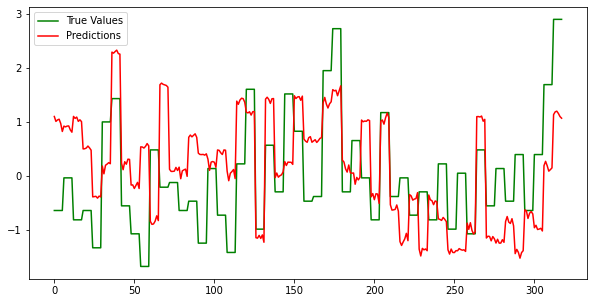

In [14]:
# Plot True Values and Predictions
plt.figure(figsize = (10,5))
plt.plot(y_test, c = 'green', label = "True Values")
plt.plot(predictions, c = "red", label = "Predictions")
plt.legend()
plt.show()

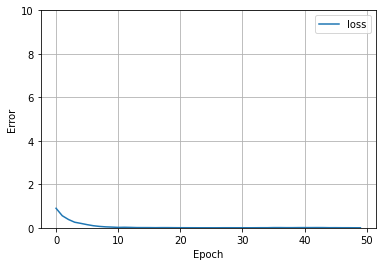

In [15]:
# Plot Loss Curves
plot_loss(history_1)

In [16]:
# Save Model
model.save('Models/Model_1')

2022-03-18 14:09:54.178747: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Models/Model_1/assets


## Preprocess 
Create Synthetic Data Using `Train` Data and Check Chi Squared Distribution and Plot the Distribution

In [17]:
# SDV 
model_copula = GaussianCopula()
model_copula.fit(train)

In [18]:
# Create a Dataset with the same number or records as training data
np.random.seed(44)
sample_data = model_copula.sample(936)
sample_data.head()

,year,week,new_york_city_diesel_average_gal,new_york_city_gas_average_gal,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,...,Unique_Drivers,Unique_Vehicles,Vehicles_Per_Day,Avg_Days_Vehicles_on_Road,Avg_Hours_Per_Day_Per_Vehicle,Avg_Days_Drivers_on_Road,Avg_Hours_Per_Day_Per_Driver,Avg_Minutes_Per_Trip,pm25,aqi
0,2020,46,3.45,2.726,69.960045,55.771458,63.915050,70.442061,54.320028,63.284315,...,715,355,177,15.5,2.0,17.6,3.3,187,18.100922,13
1,2019,48,3.36,2.441,61.785161,43.767806,53.910975,57.322831,39.137632,50.368255,...,1506,499,433,27.5,8.1,22.3,7.9,187,43.480374,36
2,2020,1,3.02,2.475,35.695044,34.002144,28.506260,31.862311,27.913897,22.886592,...,3415,2772,1756,19.9,6.9,16.1,5.8,37,30.555366,28
3,2019,6,3.30,2.413,58.365459,35.302970,52.382284,55.322803,27.846409,47.561597,...,7555,8393,5614,20.1,6.5,17.6,7.0,69,55.818691,40
4,2019,6,3.45,2.722,43.931946,25.740418,38.472756,39.386097,15.951711,32.226404,...,21811,23387,20021,20.5,5.4,22.3,6.7,53,39.798299,34


In [19]:
train.head()

,year,week,new_york_city_diesel_average_gal,new_york_city_gas_average_gal,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,...,Unique_Drivers,Unique_Vehicles,Vehicles_Per_Day,Avg_Days_Vehicles_on_Road,Avg_Hours_Per_Day_Per_Vehicle,Avg_Days_Drivers_on_Road,Avg_Hours_Per_Day_Per_Driver,Avg_Minutes_Per_Trip,pm25,aqi
0,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,7464,7410,3778,15.8,3.4,15.7,3.4,35,51.666667,34
1,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,72719,71484,46403,20.1,6.2,19.9,6.1,18,51.666667,34
2,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,13961,12751,8389,20.4,5.4,19.0,5.3,17,51.666667,34
3,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,3385,3299,1378,13.0,2.2,13.1,2.2,63,51.666667,34
4,2018,1,3.15,2.72,22.383333,12.433333,17.166667,13.2,-2.583333,4.55,...,4377,4021,2983,23.0,5.7,21.6,5.5,128,51.666667,34


### EDA

In [20]:
print(f"Distribution of Data By Year Train Data:\n{train.year.value_counts()}")
print(f"Distribution of Data By Year Train Data:\n{sample_data.year.value_counts()}")

print(f"Mean of AQI Train Data: {train.aqi.mean()}")
print(f"Mean of AQI Sample Data: {sample_data.aqi.mean()}")

Distribution of Data By Year Train Data:
2018    318
2020    318
2019    300
Name: year, dtype: int64
Distribution of Data By Year Train Data:
2019    482
2018    228
2020    226
Name: year, dtype: int64
Mean of AQI Train Data: 33.35897435897436
Mean of AQI Sample Data: 33.19337606837607


In [21]:
# Kolmogorov-Smirnov and Chi-Squared tests to compare train and sample data
from sdv.evaluation import evaluate
evaluate(sample_data, train, metrics = ['CSTest', 'KSTest'], aggregate = False)

,metric,name,raw_score,normalized_score,min_value,max_value,goal,error
0,CSTest,Chi-Squared,NaN,NaN,0.0,1.0,MAXIMIZE,"Cannot find fields of types ('boolean', 'categ..."
1,KSTest,Inverted Kolmogorov-Smirnov D statistic,0.894294,0.894294,0.0,1.0,MAXIMIZE,None


### Model
1. Create X and Y sets from Sample Data
2. Use the saved model to evalute the sample data

In [22]:
# Scale Data
sample_X_train = sample_data.drop(['pm25','aqi'], axis = 1)
sample_y_train = sample_data[['aqi']]
sample_X_train = sc_X.fit_transform(sample_X_train)
sample_y_train = sc_y.fit_transform(sample_y_train)

In [23]:
# Evaluate Data
loaded_model = tf.keras.models.load_model('Models/Model_1')

In [24]:
loaded_model.evaluate(sample_X_train, sample_y_train)

30/30 [==============================] - 0s 2ms/step - loss: 1.2419 - mean_squared_error: 1.2419


[1.241913080215454, 1.241913080215454]

The MSE is very comparable to training data MSE

#### Combine Datasets and Model and Evaluate on Test Data

In [25]:
combined_train = pd.concat([train, sample_data])
print(f"Length of Training Data: {len(combined_train)}")

# Shuffle Data
combined_train = combined_train.sample(frac=1).reset_index(drop=True)

Length of Training Data: 1872


In [26]:
# Split and Scale Data
sample_X_train = combined_train.drop(['pm25','aqi'], axis = 1)
sample_y_train = combined_train[['aqi']]
combined_X_train = sc_X.fit_transform(sample_X_train)
combined_y_train = sc_y.fit_transform(sample_y_train)

In [27]:
# Compile and Fit Model
tf.random.set_seed(44)
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
history_2 = model.fit(combined_X_train, combined_y_train, epochs=50, verbose = 0)

In [28]:
# Evaluate Model
model.evaluate(X_test, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 0.8812 - mean_squared_error: 0.8812


[0.8811631798744202, 0.8811631798744202]

In [29]:
predictions_2 = model.predict(X_test)

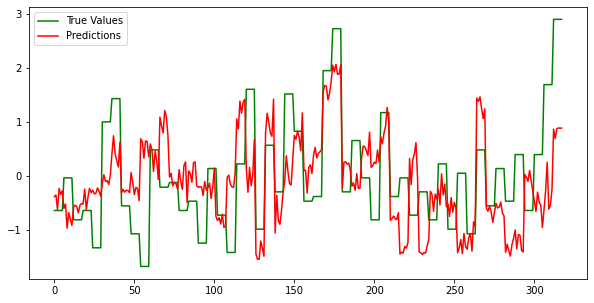

In [30]:
# Plot True Values and Predictions
plt.figure(figsize = (10,5))
plt.plot(y_test, c = 'green', label = "True Values")
plt.plot(predictions_2, c = "red", label = "Predictions")
plt.legend()
plt.show()

In [31]:
# Save Model
model.save('Models/Model_2')

INFO:tensorflow:Assets written to: Models/Model_2/assets
